In [1]:
import pandas as pd
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from einops import rearrange
import requests
import io
import json
from functools import reduce
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
import mediapy as media
import numpy as np
#from visualization_tools import game_coord_to_pixel_coord

In [2]:
run_dir = Path('session_6375c947') # Path('baselines/session_ebdfe818')
# original session_e41c9eff, main session_4da05e87, extra session_e1b6d2dc

In [3]:
def path_to_runs(pth):
    tdf = pd.read_csv(pth, compression='gzip')
    return np.array_split(tdf[tdf['map'] != 'map'], 610)

In [4]:
all_runs = [path_to_runs(pth) for pth in tqdm(run_dir.glob('*.gz'))]
all_runs = list(map(list, zip(*all_runs)))

0it [00:00, ?it/s]C:\Users\dolson\AppData\Local\Temp\ipykernel_11332\2426282693.py:2: DtypeWarning: Columns (1,2,3,4,5,6,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  tdf = pd.read_csv(pth, compression='gzip')
C:\Users\dolson\Documents\GitHub\CSCE642PokemonRedDDPG\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
1it [00:03,  3.34s/it]C:\Users\dolson\AppData\Local\Temp\ipykernel_11332\2426282693.py:2: DtypeWarning: Columns (1,2,3,4,5,6,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  tdf = pd.read_csv(pth, compression='gzip')
C:\Users\dolson\Documents\GitHub\CSCE642PokemonRedDDPG\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please

In [5]:
len(all_runs)

610

In [6]:
len(all_runs[0])

16

In [7]:
all_runs[0][0].keys()

Index(['Unnamed: 0', 'step', 'x', 'y', 'map', 'last_action', 'pcount',
       'levels', 'ptypes', 'hp', 'frames', 'deaths', 'badge', 'event',
       'healr'],
      dtype='object')

In [8]:
poke_id_to_name = {
    177: "Squirtle",
    255: "None",
    0: "None",
    165: "Rattata",
    36: "Pidgey",
    179: "Wartortle",
    150: "Pidgeotto",
    112: "Weedle",
    113: "Kakuna",
    114: "Beedrill",
    133: "Magikarp",
    169: "Geodude",
    107: "Zubat",
    109: "Paras",
    100: "Jigglypuff",
    84: "Pikachu",
    123: "Caterpie",
    124: "Metapod",
    4: "Clefairy",
    5: "Spearow",
    15: "Nidoran♀"
}
valid_list = [name for name in poke_id_to_name.values() if name != 'None']
valid_list

['Squirtle',
 'Rattata',
 'Pidgey',
 'Wartortle',
 'Pidgeotto',
 'Weedle',
 'Kakuna',
 'Beedrill',
 'Magikarp',
 'Geodude',
 'Zubat',
 'Paras',
 'Jigglypuff',
 'Pikachu',
 'Caterpie',
 'Metapod',
 'Clefairy',
 'Spearow',
 'Nidoran♀']

In [9]:
poke_colors = {
 'Squirtle': (116, 196, 215),
 'Rattata': (157, 134, 162),
 'Pidgey': (190, 157, 119),
 'Wartortle': (80, 156, 214),
 'Pidgeotto': (233, 128, 118),
 'Weedle': (190, 150, 81),
 'Kakuna': (226, 200, 123),
 'Magikarp': (244, 119, 87),
 'Geodude': (176, 176, 176),
 'Zubat': (157, 82, 175),
 'Paras': (241, 171, 100),
 'Jigglypuff': (255, 200, 220),
 'Pikachu': (252, 244, 107),
 'Metapod': (162, 222, 80),
 'Clefairy': (218, 165, 183),
 'Spearow': (163, 75, 71),
 'Nidoran♀': (163, 167, 205),
 'Beedrill': (255,211,109),
 'Caterpie': (125, 206, 104)
}

In [10]:
# count times each pokemon caught
all_poke_counts = []
missing_poke = set()
for run in tqdm(all_runs):
    p_counts = {p:0 for p in valid_list}
    for sim_df in run:
        caught_pokes = set()
        for step in sim_df['ptypes']:
            party = json.loads(step)
            for p in party:
                if p in poke_id_to_name.keys():
                    pname = poke_id_to_name[p]
                    caught_pokes.add(pname)
                elif p not in missing_poke:
                    missing_poke.add(p)
                    print(f'missing poke id: {p}')
        for p in caught_pokes:
            if p == 'None':
                continue
            if p in p_counts.keys():
                p_counts[p] += 1
            else:
                p_counts[p] = 1
    all_poke_counts.append(p_counts)
        

  9%|▉         | 56/610 [00:08<01:25,  6.46it/s]

missing poke id: 3


100%|██████████| 610/610 [01:31<00:00,  6.67it/s]


In [11]:
all_poke_counts

[{'Squirtle': 16,
  'Rattata': 1,
  'Pidgey': 4,
  'Wartortle': 0,
  'Pidgeotto': 0,
  'Weedle': 0,
  'Kakuna': 0,
  'Beedrill': 0,
  'Magikarp': 0,
  'Geodude': 0,
  'Zubat': 0,
  'Paras': 0,
  'Jigglypuff': 0,
  'Pikachu': 0,
  'Caterpie': 0,
  'Metapod': 0,
  'Clefairy': 0,
  'Spearow': 0,
  'Nidoran♀': 0},
 {'Squirtle': 16,
  'Rattata': 3,
  'Pidgey': 5,
  'Wartortle': 0,
  'Pidgeotto': 0,
  'Weedle': 0,
  'Kakuna': 0,
  'Beedrill': 0,
  'Magikarp': 0,
  'Geodude': 0,
  'Zubat': 0,
  'Paras': 0,
  'Jigglypuff': 0,
  'Pikachu': 0,
  'Caterpie': 0,
  'Metapod': 0,
  'Clefairy': 0,
  'Spearow': 0,
  'Nidoran♀': 0},
 {'Squirtle': 16,
  'Rattata': 4,
  'Pidgey': 6,
  'Wartortle': 0,
  'Pidgeotto': 0,
  'Weedle': 0,
  'Kakuna': 0,
  'Beedrill': 0,
  'Magikarp': 0,
  'Geodude': 0,
  'Zubat': 0,
  'Paras': 0,
  'Jigglypuff': 0,
  'Pikachu': 0,
  'Caterpie': 0,
  'Metapod': 0,
  'Clefairy': 0,
  'Spearow': 0,
  'Nidoran♀': 0},
 {'Squirtle': 16,
  'Rattata': 4,
  'Pidgey': 6,
  'Wartortle': 

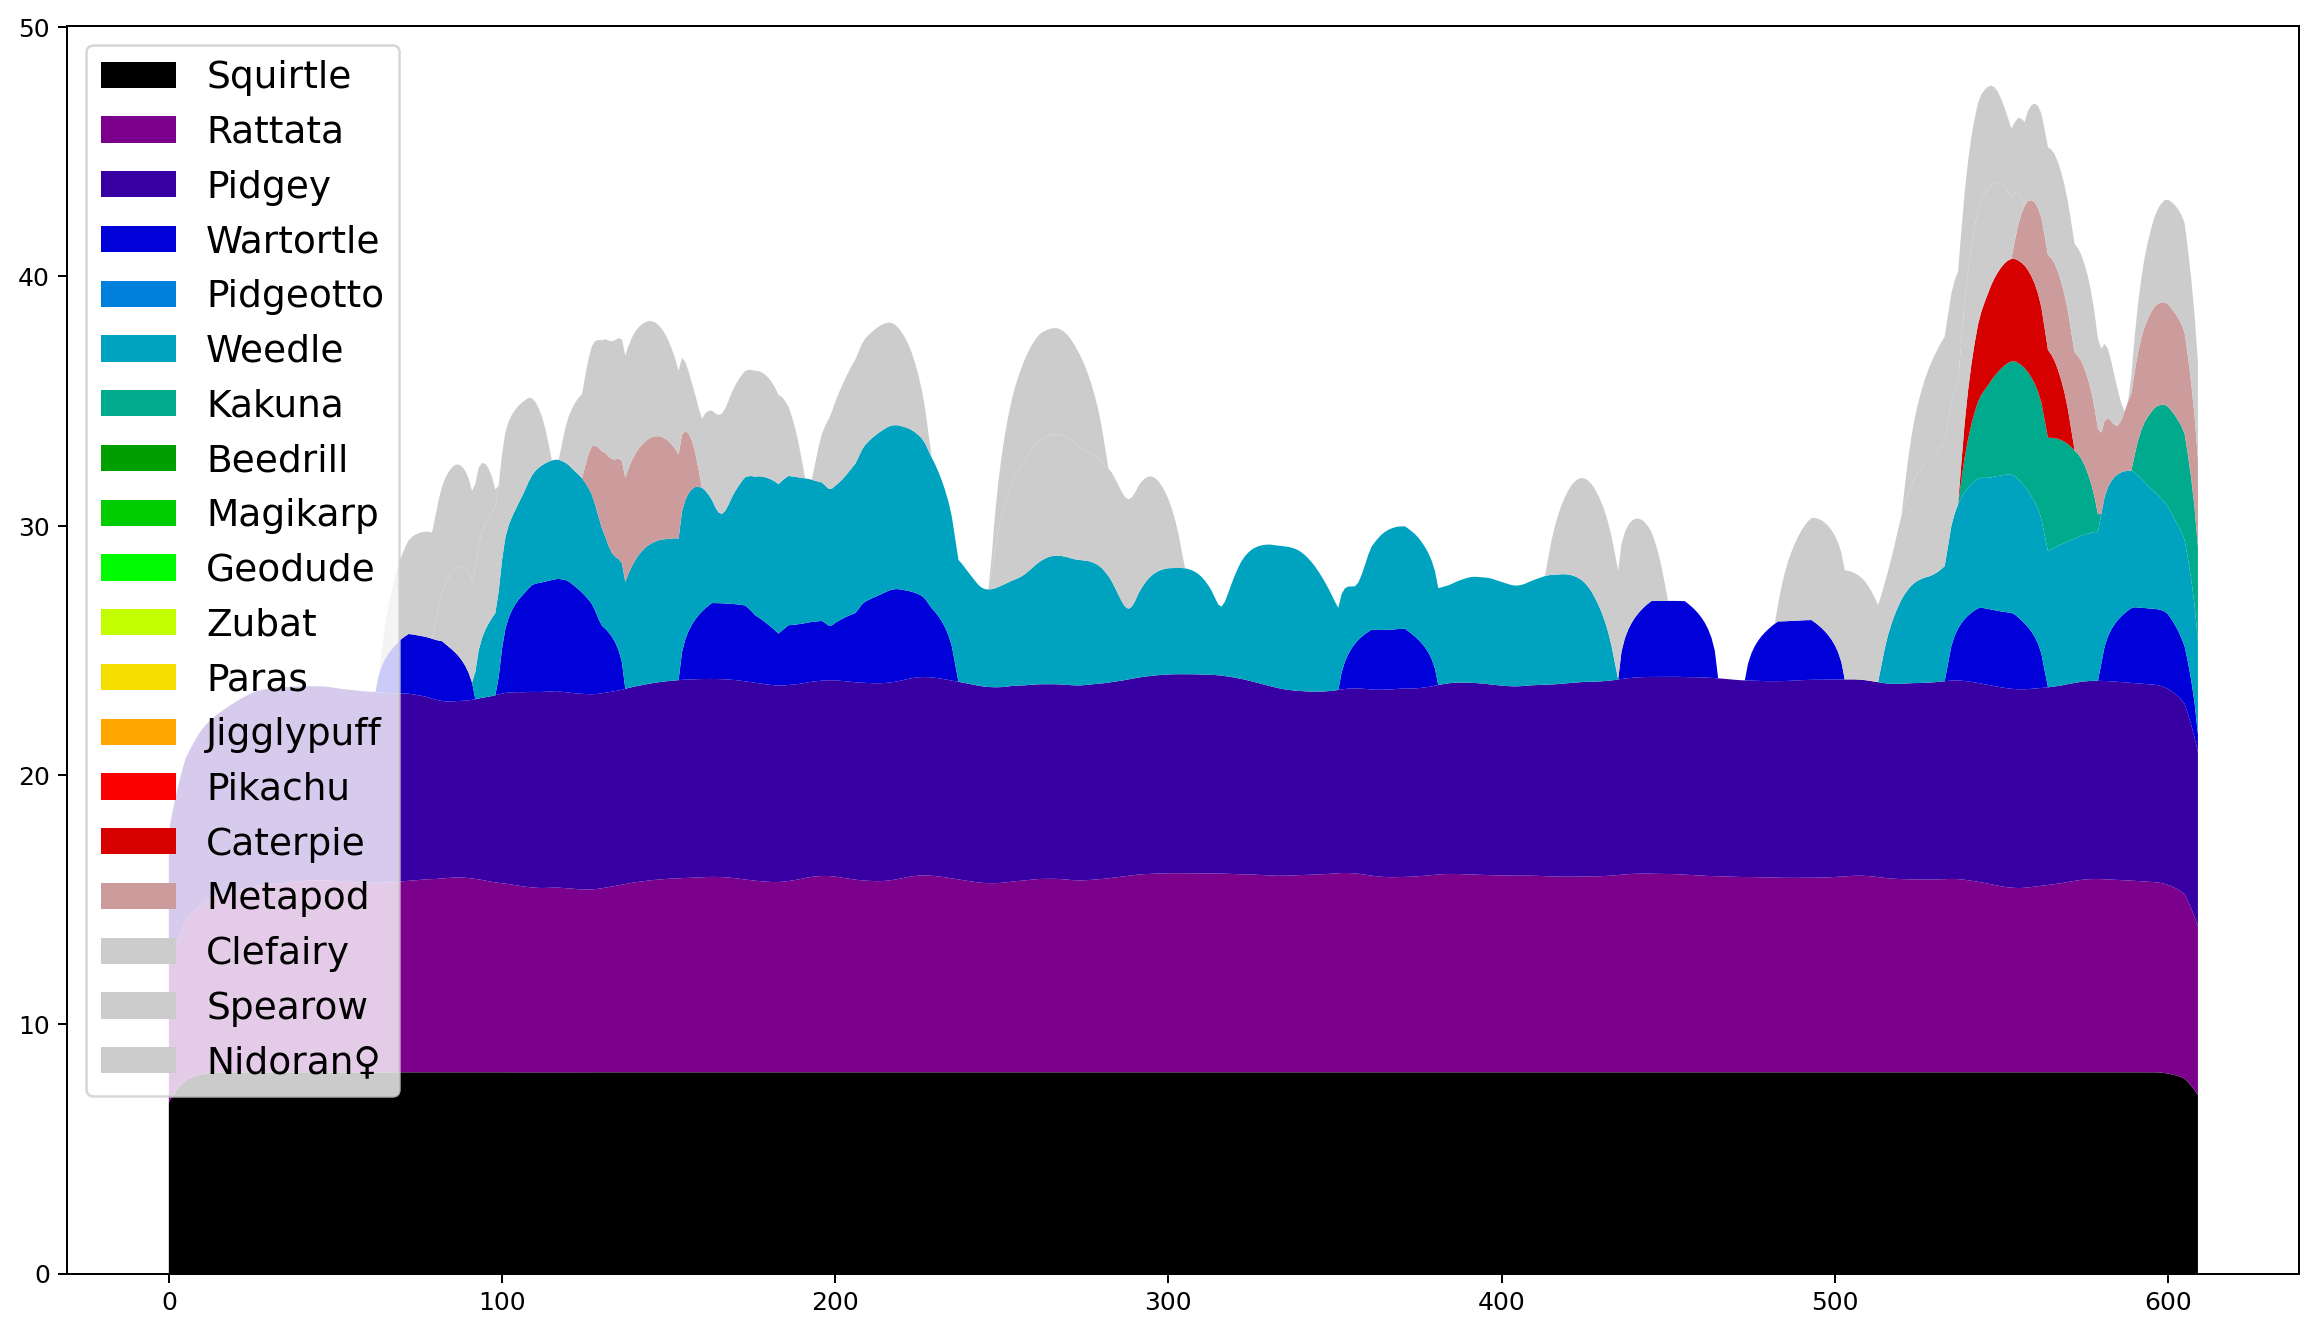

In [12]:
steps = len(all_poke_counts)
x = range(steps)
raw_counts = np.array(list(zip(*[list(counts.values()) for counts in all_poke_counts])))
raw_counts = [np.convolve(rc, np.ones(20), mode='same') for rc in raw_counts]
raw_counts = [np.log(1+np.convolve(rc, np.ones(10), mode='same')) for rc in raw_counts]
plt.figure(figsize=(16, 9), dpi=180)
cols = iter(plt.cm.nipy_spectral(np.linspace(0, 40, steps)))
plt.stackplot(x, *raw_counts, labels=valid_list, colors=cols)
plt.legend(loc='upper left', prop={'size': 15})

In [13]:
base_stats = {
    'pcount': 0, 
    'total_levels': 0, 'frames': 0, 'deaths': 0, 
    'event': 0, 'healr': 0, 'badge': 0
}

In [14]:
def df_to_numpy(df):
    # load levels and sum
    df['total_levels'] = df['levels'].map(lambda x: sum(json.loads(x)))
    #df = df.drop(columns=['levels', 'ptypes', 'Unnamed: 0', 'step', ])
    #df['gcoords'] = df.apply(
    #    lambda r: fastish(r['x'], r['y'], r['map'], 4000), axis=1)
    #df['gx'] = df['gcoords'].map(lambda c: c[0])
    #df['gy'] = df['gcoords'].map(lambda c: c[1])
    # select only relevant stats and convert all to floats
    return df[base_stats.keys()].applymap(lambda v: float(v)).to_numpy()

In [15]:
df_to_numpy(all_runs[0][0]).shape

C:\Users\dolson\AppData\Local\Temp\ipykernel_11332\3743885565.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df[base_stats.keys()].applymap(lambda v: float(v)).to_numpy()


(2687, 7)

In [16]:
name_to_idx = {name:idx for idx, name in enumerate(base_stats.keys())}
name_to_idx

{'pcount': 0,
 'total_levels': 1,
 'frames': 2,
 'deaths': 3,
 'event': 4,
 'healr': 5,
 'badge': 6}

In [17]:
big_dat = np.array([[df_to_numpy(run) for run in batch] for batch in tqdm(all_runs)], dtype="object")
#df_to_numpy(all_runs[0][0]).shape

  0%|          | 0/610 [00:00<?, ?it/s]C:\Users\dolson\AppData\Local\Temp\ipykernel_11332\3743885565.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df[base_stats.keys()].applymap(lambda v: float(v)).to_numpy()
C:\Users\dolson\AppData\Local\Temp\ipykernel_11332\3743885565.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df[base_stats.keys()].applymap(lambda v: float(v)).to_numpy()
C:\Users\dolson\AppData\Local\Temp\ipykernel_11332\3743885565.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df[base_stats.keys()].applymap(lambda v: float(v)).to_numpy()
C:\Users\dolson\AppData\Local\Temp\ipykernel_11332\3743885565.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df[base_stats.keys()].applymap(lambda v: float(v)).to_numpy()
C:\Users\dolson\AppData\Local\Temp\ipykernel_11332\3743885565.py:10: Futu

In [18]:
big_dat.shape

(610, 16)

In [19]:
big_dat[:,:,:,0].mean(axis=1).shape

IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

In [20]:
rearrange(big_dat, '(r x) b s d -> r (x b) s d', x=1).shape

EinopsError:  Error while processing rearrange-reduction pattern "(r x) b s d -> r (x b) s d".
 Input tensor shape: (610, 16). Additional info: {'x': 1}.
 Wrong shape: expected 4 dims. Received 2-dim tensor.

In [21]:
the_dat = 'total_levels'
steps = 100
start_step = 130
combine_steps = 5
plot_dat = rearrange(
    big_dat, '(r x) b s d -> r (x b) s d', x=combine_steps
    )[:, :, :, name_to_idx[the_dat]].mean(axis=1)
for i in range(len(plot_dat)):
    plot_dat[i] = gaussian_filter(plot_dat[i], 100.0, mode='nearest')
with media.VideoWriter(f'{the_dat}.mp4', (1080, 1920)) as wr:
    for i in tqdm(np.geomspace(start_step, plot_dat.shape[1]+1, num=steps)):
        i = int(i)
        #with plt.style.context('Solarize_Light2'):
        fig = plt.figure(figsize=(16, 9), dpi=120)
        for idx, dat in enumerate(plot_dat[:,:i]):
            plt.plot(dat, color=plt.cm.jet(idx/plot_dat.shape[0]))

        # Number of accent colors in the color scheme
        plt.title(the_dat)
        plt.xlabel('game actions', fontsize=14)
        plt.ylabel(the_dat, fontsize=14)

        fig.canvas.draw()
        #plt.show()
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        wr.add_image(data)
        plt.close()

EinopsError:  Error while processing rearrange-reduction pattern "(r x) b s d -> r (x b) s d".
 Input tensor shape: (610, 16). Additional info: {'x': 5}.
 Wrong shape: expected 4 dims. Received 2-dim tensor.

In [22]:
the_dat = 'deaths'
steps = 100
start_step = 20
combine_steps = 10
plot_dat = rearrange(
    big_dat, '(r x) b s d -> r (x b) s d', x=combine_steps
    )[:, :, :, name_to_idx[the_dat]].mean(axis=1)
for i in range(len(plot_dat)):
    plot_dat[i] = gaussian_filter(plot_dat[i], 100.0, mode='nearest')
with media.VideoWriter(f'{the_dat}.mp4', (1080, 1920)) as wr:
    for i in tqdm(np.geomspace(start_step, plot_dat.shape[1]+1, num=steps)):
        i = int(i)
        #with plt.style.context('Solarize_Light2'):
        fig = plt.figure(figsize=(16, 9), dpi=120)
        for idx, dat in enumerate(plot_dat[:,:i]):
            plt.plot(dat, color=plt.cm.turbo(idx/plot_dat.shape[0]))

        # Number of accent colors in the color scheme
        plt.title(the_dat)
        plt.xlabel('game actions', fontsize=14)
        plt.ylabel(the_dat, fontsize=14)
        fig.canvas.draw()
        #plt.show()
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        wr.add_image(data)
        
        plt.close()

EinopsError:  Error while processing rearrange-reduction pattern "(r x) b s d -> r (x b) s d".
 Input tensor shape: (610, 16). Additional info: {'x': 10}.
 Wrong shape: expected 4 dims. Received 2-dim tensor.

In [24]:
# flipped so we can see progression differently
the_dat = 'total_levels'
steps = 10
start_step = 20
combine_steps = 1
plot_dat = rearrange(
    big_dat, '(r x) b s d -> r (x b) s d', x=combine_steps
    )[:, :, :, name_to_idx[the_dat]].mean(axis=1)
print(plot_dat.shape)
for i in range(len(plot_dat)):
    plot_dat[i] = gaussian_filter(plot_dat[i], 100.0, mode='nearest')
with media.VideoWriter(f'{the_dat}.mp4', (1080, 1920)) as wr:
    for i in tqdm(np.geomspace(start_step, plot_dat.shape[1]+1, num=steps)):
        i = int(i)
        #with plt.style.context('Solarize_Light2'):
        fig = plt.figure(figsize=(16, 9), dpi=120)
        for idx, dat in enumerate(plot_dat[:,:i]):
            plt.plot(dat, color=plt.cm.turbo(idx/plot_dat.shape[0]))

        # Number of accent colors in the color scheme
        plt.title(the_dat)
        plt.xlabel('game actions', fontsize=14)
        plt.ylabel(the_dat, fontsize=14)
        fig.canvas.draw()
        #plt.show()
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        wr.add_image(data)
        
        plt.close()

(610, 16385)


100% 10/10 [00:07<00:00,  1.41it/s]


In [25]:
all_poke_counts[0]

{'Squirtle': 44,
 'Rattata': 31,
 'Pidgey': 29,
 'Wartortle': 0,
 'Pidgeotto': 0,
 'Weedle': 0,
 'Kakuna': 0,
 'Beedrill': 0,
 'Magikarp': 0,
 'Geodude': 0,
 'Zubat': 0,
 'Paras': 0,
 'Jigglypuff': 0,
 'Pikachu': 0,
 'Caterpie': 0,
 'Metapod': 0,
 'Clefairy': 0,
 'Spearow': 0,
 'Nidoran♀': 0}

In [29]:
mix_val = 0.1

with media.VideoWriter(f'poke_pie.mp4', (1080, 1920)) as wr:
    vals = {p:0 for p in valid_list}
    for cur_poke in tqdm(all_poke_counts):
        #with plt.style.context('Solarize_Light2'):
        fig = plt.figure(figsize=(16, 9), dpi=120)
        # Pie chart, where the slices will be ordered and plotted counter-clockwise:
        for name, count in vals.items():
            cc = 0
            if name in cur_poke.keys():
                cc = cur_poke[name]
            vals[name] = count * (1-mix_val) + cc*mix_val
            
        poke_filtered = {name:count for name, count in vals.items() if count > 0}
        explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

        plt.pie(
            poke_filtered.values(), labels=poke_filtered.keys(), 
            colors=[np.array(poke_colors[p])/255 for p in poke_filtered.keys()], autopct='%1.1f%%',
            shadow=False, startangle=90)
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

        fig.canvas.draw()
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        wr.add_image(data)
        
        plt.close()

 25% 154/610 [00:06<00:20, 22.01it/s]


KeyError: 'Caterpie'

<Figure size 1920x1080 with 0 Axes>

In [31]:
my_df = pd.DataFrame(all_poke_counts).transpose()#.to_csv('cool_poke_data.csv') 
my_df

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
Squirtle,44,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44
Rattata,31,31,27,32,28,35,35,33,38,32,...,26,30,30,29,34,36,30,36,32,31
Pidgey,29,34,33,28,34,31,36,41,39,39,...,27,29,39,36,42,41,37,38,31,25
Wartortle,0,0,0,0,0,0,0,0,2,6,...,37,40,35,34,35,37,40,40,42,42
Pidgeotto,0,0,0,0,0,0,0,0,0,0,...,2,0,6,4,3,2,2,3,2,4
Weedle,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Kakuna,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Beedrill,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Magikarp,0,0,0,0,0,0,0,0,0,0,...,37,34,27,27,32,32,31,38,43,39
Geodude,0,0,0,0,0,0,0,0,0,0,...,2,1,1,2,0,0,1,0,0,1


In [32]:
new_df = pd.DataFrame()
mg = 4
for c in range(len(my_df.columns)//mg):
    new_df[c*3] = (my_df[c*mg] + my_df[c*mg+1] + my_df[c*mg+2] + my_df[c*mg+3]) / (mg*5/100)
new_df = new_df.copy()
new_df.to_csv('cool_poke_data.csv') 

/tmp/ipykernel_18232/1941257315.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[c*3] = (my_df[c*mg] + my_df[c*mg+1] + my_df[c*mg+2] + my_df[c*mg+3]) / (mg*5/100)
/tmp/ipykernel_18232/1941257315.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[c*3] = (my_df[c*mg] + my_df[c*mg+1] + my_df[c*mg+2] + my_df[c*mg+3]) / (mg*5/100)
/tmp/ipykernel_18232/1941257315.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

/tmp/ipykernel_18232/1941257315.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[c*3] = (my_df[c*mg] + my_df[c*mg+1] + my_df[c*mg+2] + my_df[c*mg+3]) / (mg*5/100)
/tmp/ipykernel_18232/1941257315.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[c*3] = (my_df[c*mg] + my_df[c*mg+1] + my_df[c*mg+2] + my_df[c*mg+3]) / (mg*5/100)
/tmp/ipykernel_18232/1941257315.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

In [28]:
# total pokemon caught!
tot_caught = 0
for run in all_poke_counts:
    for name,count in run.items():
        if name != 'Squirtle':
            tot_caught += count
tot_caught

66816

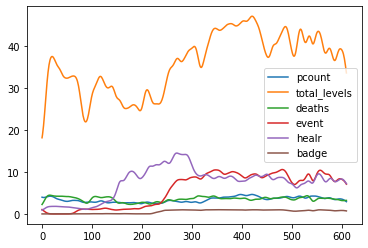

In [150]:
for name in name_to_idx.keys():
    if name == 'frames':
        continue
    plt.plot(
        gaussian_filter(
            big_dat[:, :, -1, name_to_idx[name]].mean(axis=1)
        , 5.0, mode='nearest'),
        label=name
    )
    plt.legend()

In [76]:
# frames gets reset! when level threshold is reached knn index is reset and rews are rebalanced

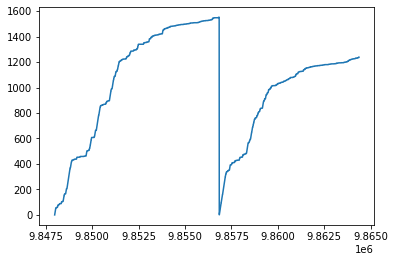

In [70]:
plt.plot(all_runs[601][0]['frames'].map(int))

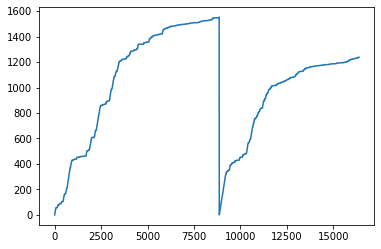

In [71]:
plt.plot(big_dat[601, 0, :, name_to_idx['frames']])

In [22]:
name_to_idx

{'pcount': 0,
 'total_levels': 1,
 'frames': 2,
 'deaths': 3,
 'event': 4,
 'healr': 5}

In [192]:
!du -h ./* | sort -hr

3.8G	./session_4da05e87_main_good
2.2G	./session_e41c9eff_start_maybe
1.2G	./session_b30478f4_mt_moon
780M	./session_4ba3e68a/rollouts
780M	./session_4ba3e68a
750M	./session_e62631a0
524M	./session_6228d517
492M	./session_12ec2684
409M	./session_ebdfe818
288M	./mini_agent_stats
258M	./session_ff005d39
217M	./session_f3005434
215M	./session_e1b6d2dc_post_train_more_steps
195M	./session_21d79997
171M	./lvl_22/rollouts
171M	./lvl_22
161M	./session_2fe0ddf4_fixed_lr
156M	./session_d9628af6/rollouts
156M	./session_d9628af6
150M	./session_cc7a5d07/rollouts
150M	./session_cc7a5d07
149M	./session_bdc7501c/rollouts
149M	./session_bdc7501c
136M	./session_trains_good_party
134M	./session_9484a86d/rollouts
134M	./session_9484a86d
133M	./session_trains_good_party/rollouts
128M	./session_podex_start
128M	./session_3fe1d05b/rollouts
128M	./session_3fe1d05b
122M	./session_cf7d4662/rollouts
122M	./session_cf7d4662
115M	./session_45a0b294
113M	./session_6529b0d7/rollouts
113M	./session_6529b0d7
113M	./s

In [208]:
!ls session_e41c9eff_start_maybe

poke_100204544_steps.zip poke_175177728_steps.zip poke_250871808_steps.zip
poke_100925440_steps.zip poke_175898624_steps.zip poke_25231360_steps.zip
poke_10092544_steps.zip  poke_176619520_steps.zip poke_25952256_steps.zip
poke_101646336_steps.zip poke_177340416_steps.zip poke_26673152_steps.zip
poke_102367232_steps.zip poke_178061312_steps.zip poke_27394048_steps.zip
poke_103088128_steps.zip poke_178782208_steps.zip poke_28114944_steps.zip
poke_103809024_steps.zip poke_179503104_steps.zip poke_28835840_steps.zip
poke_104529920_steps.zip poke_180224000_steps.zip poke_2883584_steps.zip
poke_105250816_steps.zip poke_18022400_steps.zip  poke_29556736_steps.zip
poke_105971712_steps.zip poke_180944896_steps.zip poke_30277632_steps.zip
poke_106692608_steps.zip poke_181665792_steps.zip poke_30998528_steps.zip
poke_107413504_steps.zip poke_182386688_steps.zip poke_31719424_steps.zip
poke_108134400_steps.zip poke_183107584_steps.zip poke_32440320_steps.zip
poke_10813440_steps.zip  poke_18382848

In [204]:
with open('session_39dadd25/all_runs_9e0643ff.json') as f:
    stats = json.load(f)

In [205]:
stats

[{'events': 325,
  'party_xp': 339.75,
  'levels': 270,
  'op_level': 1100,
  'op_poke': 300,
  'seen_poke': 400,
  'explore': 669}]